# Self-Driving Car Engineer Nanodegree


## Project: **Finding Lane Lines on the Road** 
***
In this project, you will use the tools you learned about in the lesson to identify lane lines on the road.  You can develop your pipeline on a series of individual images, and later apply the result to a video stream (really just a series of images). Check out the video clip "raw-lines-example.mp4" (also contained in this repository) to see what the output should look like after using the helper functions below. 

Once you have a result that looks roughly like "raw-lines-example.mp4", you'll need to get creative and try to average and/or extrapolate the line segments you've detected to map out the full extent of the lane lines.  You can see an example of the result you're going for in the video "P1_example.mp4".  Ultimately, you would like to draw just one line for the left side of the lane, and one for the right.

In addition to implementing code, there is a brief writeup to complete. The writeup should be completed in a separate file, which can be either a markdown file or a pdf document. There is a [write up template](https://github.com/udacity/CarND-LaneLines-P1/blob/master/writeup_template.md) that can be used to guide the writing process. Completing both the code in the Ipython notebook and the writeup template will cover all of the [rubric points](https://review.udacity.com/#!/rubrics/322/view) for this project.

---
Let's have a look at our first image called 'test_images/solidWhiteRight.jpg'.  Run the 2 cells below (hit Shift-Enter or the "play" button above) to display the image.

**Note: If, at any point, you encounter frozen display windows or other confounding issues, you can always start again with a clean slate by going to the "Kernel" menu above and selecting "Restart & Clear Output".**

---

**The tools you have are color selection, region of interest selection, grayscaling, Gaussian smoothing, Canny Edge Detection and Hough Tranform line detection.  You  are also free to explore and try other techniques that were not presented in the lesson.  Your goal is piece together a pipeline to detect the line segments in the image, then average/extrapolate them and draw them onto the image for display (as below).  Once you have a working pipeline, try it out on the video stream below.**

---

<figure>
 <img src="line-segments-example.jpg" width="380" alt="Combined Image" />
 <figcaption>
 <p></p> 
 <p style="text-align: center;"> Your output should look something like this (above) after detecting line segments using the helper functions below </p> 
 </figcaption>
</figure>
 <p></p> 
<figure>
 <img src="laneLines_thirdPass.jpg" width="380" alt="Combined Image" />
 <figcaption>
 <p></p> 
 <p style="text-align: center;"> Your goal is to connect/average/extrapolate line segments to get output like this</p> 
 </figcaption>
</figure>

**Run the cell below to import some packages.  If you get an `import error` for a package you've already installed, try changing your kernel (select the Kernel menu above --> Change Kernel).  Still have problems?  Try relaunching Jupyter Notebook from the terminal prompt.  Also, see [this forum post](https://carnd-forums.udacity.com/cq/viewquestion.action?spaceKey=CAR&id=29496372&questionTitle=finding-lanes---import-cv2-fails-even-though-python-in-the-terminal-window-has-no-problem-with-import-cv2) for more troubleshooting tips.**  

## Import Packages

In [1]:
#importing some useful packages
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import cv2
%matplotlib inline

import math
import os

## Read in an Image

This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)


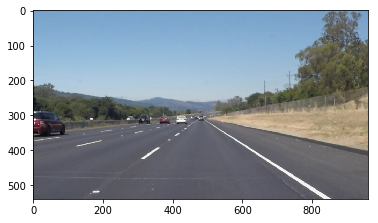

In [2]:
#reading in an image
image = mpimg.imread('test_images/solidWhiteRight.jpg')

#printing out some stats and plotting
print('This image is:', type(image), 'with dimensions:', image.shape)
_ = plt.imshow(image)  # if you wanted to show a single color channel image called 'gray', for example, call as plt.imshow(gray, cmap='gray')

## Ideas for Lane Detection Pipeline

**Some OpenCV functions (beyond those introduced in the lesson) that might be useful for this project are:**

`cv2.inRange()` for color selection  
`cv2.fillPoly()` for regions selection  
`cv2.line()` to draw lines on an image given endpoints  
`cv2.addWeighted()` to coadd / overlay two images
`cv2.cvtColor()` to grayscale or change color
`cv2.imwrite()` to output images to file  
`cv2.bitwise_and()` to apply a mask to an image

**Check out the OpenCV documentation to learn about these and discover even more awesome functionality!**

## Helper Functions

Below are some helper functions to help get you started. They should look familiar from the lesson!

In [3]:
# Left unchanged
def grayscale(img):
    """Applies the Grayscale transform
    This will return an image with only one color channel
    but NOTE: to see the returned image as grayscale
    (assuming your grayscaled image is called 'gray')
    you should call plt.imshow(gray, cmap='gray')"""
    return cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # Or use BGR2GRAY if you read an image with cv2.imread()
    # return cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    
# Left unchanged    
def canny(img, low_threshold, high_threshold):
    """Applies the Canny transform"""
    return cv2.Canny(img, low_threshold, high_threshold)

# Left unchanged
def gaussian_blur(img, kernel_size):
    """Applies a Gaussian Noise kernel"""
    return cv2.GaussianBlur(img, (kernel_size, kernel_size), 0)

# Left unchanged
def region_of_interest(img, vertices):
    """
    Applies an image mask.
    
    Only keeps the region of the image defined by the polygon
    formed from `vertices`. The rest of the image is set to black.
    """
    #defining a blank mask to start with
    mask = np.zeros_like(img)   
    
    #defining a 3 channel or 1 channel color to fill the mask with depending on the input image
    if len(img.shape) > 2:
        channel_count = img.shape[2]  # i.e. 3 or 4 depending on your image
        ignore_mask_color = (255,) * channel_count
    else:
        ignore_mask_color = 255
        
    #filling pixels inside the polygon defined by "vertices" with the fill color    
    cv2.fillPoly(mask, vertices, ignore_mask_color)
    
    #returning the image only where mask pixels are nonzero
    masked_image = cv2.bitwise_and(img, mask)
    return masked_image

# Helper for the new version of draw_lines that smooths current frame data
# based on data from previous frames by weighted averaging
def frame_smooth(frame, history, history_length):
    l = len(history)
    
    if l < history_length:
        history.insert(0, frame)
        return frame
    
    w_step = 1/(history_length + 1)
    
    i = l
    wi = w_step
    w = 0
    s = [0]*len(frame)    
    history.insert(0, frame)

    while i>=0:
        for k in range(0, len(s)):
            s[k] += wi * history[i][k]
        w += wi
        wi += w_step
        i -=1
        
    for k in range(0, len(frame)):
        history[0][k] = s[k] / w
        
    smoothed = history[0]    
        
    if l+1 > history_length:
        history.pop()
        
    return smoothed 

# Helper for the new version of draw_lines that filters out lines-outliers
def filter_lines(lines):
    slopes = [pair[0] for pair in lines]
    intercepts = [pair[1] for pair in lines]
    
    if (not slopes) | (not intercepts):
        return []
    
    slopes_Q1 = np.percentile(slopes, 25)
    slopes_Q3 = np.percentile(slopes, 50)
    slopes_IQR = slopes_Q3 - slopes_Q1
    
    intercepts_Q1 = np.percentile(intercepts, 25)
    intercepts_Q3 = np.percentile(intercepts, 50)
    intercepts_IQR = intercepts_Q3 - intercepts_Q1    
    
    lines_kept = []
    for pair in lines:
        if (pair[0] >= slopes_Q1 - 1.5 * slopes_IQR)&(pair[0] <= slopes_Q3 + 1.5 * slopes_IQR)&\
           (pair[1] >= intercepts_Q1 - 1.5 * intercepts_IQR)&(pair[1] <= intercepts_Q3 + 1.5 * intercepts_IQR):
            lines_kept += [pair]
            
    return lines_kept

# Helper for the new version of draw_lines that draws final averaged line (left or right)
def draw_avg_line(img, lines, apex_v, color, thickness, history, history_length):
    if lines:  
        a = np.mean([pair[0] for pair in lines])
        b = np.mean([pair[1] for pair in lines])
        frame = frame_smooth([a, b], history, history_length)
        a = frame[0]
        b = frame[1]
        
        y_bottom = img.shape[0]
        y_apex = y_bottom * apex_v          
    
        x1 = int(round((y_bottom - b)/a))
        y1 = y_bottom
        x2 = int(round((y_apex - b)/a))
        y2 = int(round(y_apex))
        cv2.line(img, (x1, y1), (x2, y2), color, thickness)

# For Debugging only. Draws all detected lines extrapolated for the whole region of interest         
def draw_every_line(img, lines, apex_v, thickness=2):
    y_bottom = img.shape[0]
    y_apex = y_bottom * apex_v 
    
    if lines:
        for pair in lines:
            slope = pair[0]
            intercept = pair[1]
                
            y1 = int(round(y_bottom))
            x1 = int(round( (y1 - intercept)/slope ))
                
            y2 = int(round(y_apex))
            x2 = int(round((y2 - intercept)/slope))
                
            if slope > 0:
                color = [0,250,0]
            else:
                color = [0,0,250]
                        
            cv2.line(img, (x1, y1), (x2, y2), color, thickness)

# New version of draw_lines
def draw_lines(img, lines, history, history_length, slope_threshold, apex_v, color=[250, 0, 0], thickness=5):
    left = []
    right = []

    for line in lines:
        for x1,y1,x2,y2 in line:
            if (x1!=x2)&(y1!=y2): # eliminate vertical and horizontal lines
                slope = (y2-y1)/(x2-x1)
                
                if np.abs(slope) > slope_threshold:
                    intercept = y1 - slope*x1

                    if slope < 0:
                        left += [[slope, intercept]]
                    else:
                        right += [[slope, intercept]]
                    
    left = filter_lines(left)
    right = filter_lines(right)
    
    #For Debugging only
    #draw_every_line(img, left, apex_v)
    #draw_every_line(img, right, apex_v)    
    
    #Draw left and Right lines 
    draw_avg_line(img, left, apex_v, color, thickness, history['left'], history_length)
    draw_avg_line(img, right, apex_v, color, thickness, history['right'], history_length)            

# Previously version of draw_lines     
def draw_lines_initial(img, lines, color=[255, 0, 0], thickness=2):
    """
    NOTE: this is the function you might want to use as a starting point once you want to 
    average/extrapolate the line segments you detect to map out the full
    extent of the lane (going from the result shown in raw-lines-example.mp4
    to that shown in P1_example.mp4).  
    
    Think about things like separating line segments by their 
    slope ((y2-y1)/(x2-x1)) to decide which segments are part of the left
    line vs. the right line.  Then, you can average the position of each of 
    the lines and extrapolate to the top and bottom of the lane.
    
    This function draws `lines` with `color` and `thickness`.    
    Lines are drawn on the image inplace (mutates the image).
    If you want to make the lines semi-transparent, think about combining
    this function with the weighted_img() function below
    """
    for line in lines:
        for x1,y1,x2,y2 in line:
            cv2.line(img, (x1, y1), (x2, y2), color, thickness)
            
# Updated to take additional parameters for draw_lines            
def hough_lines(img, history, history_length, Hough_only, rho, theta, threshold, min_line_len, max_line_gap, slope_threshold, apex_v):
    """
    `img` should be the output of a Canny transform.
        
    Returns an image with hough lines drawn.
    """
    lines = cv2.HoughLinesP(img, rho, theta, threshold, np.array([]), minLineLength=min_line_len, maxLineGap=max_line_gap)
    line_img = np.zeros((img.shape[0], img.shape[1], 3), dtype=np.uint8)
    
    if Hough_only:
        draw_lines_initial(line_img, lines)
    else:    
        draw_lines(line_img, lines, history, history_length, slope_threshold=slope_threshold, apex_v=apex_v)
        
    return line_img            

# Left unchanged
# Python 3 has support for cool math symbols.
def weighted_img(img, initial_img, α=0.8, β=1., λ=0.):
    """
    `img` is the output of the hough_lines(), An image with lines drawn on it.
    Should be a blank image (all black) with lines drawn on it.
    
    `initial_img` should be the image before any processing.
    
    The result image is computed as follows:
    
    initial_img * α + img * β + λ
    NOTE: initial_img and img must be the same shape!
    """
    return cv2.addWeighted(initial_img, α, img, β, λ)

## Test Images

Build your pipeline to work on the images in the directory "test_images"  
**You should make sure your pipeline works well on these images before you try the videos.**

In [4]:
os.listdir("test_images/")

['solidWhiteCurve.jpg',
 'solidWhiteRight.jpg',
 'solidYellowCurve.jpg',
 'solidYellowCurve2.jpg',
 'solidYellowLeft.jpg',
 'whiteCarLaneSwitch.jpg']

## Build a Lane Finding Pipeline

Build the pipeline and run your solution on all test_images. Make copies into the test_images directory, and you can use the images in your writeup report.

Try tuning the various parameters, especially the low and high Canny thresholds as well as the Hough lines parameters.

In [5]:
# TODO: Build your pipeline that will draw lane lines on the test_images
# then save them to the test_images directory.

In [6]:
# Drawing lines on a single image taking into account set of parameters and historical data from previous frames
def detect_lanes(image, history, parameters):
   
    # Grayscale the image
    gray_image = grayscale(image)

    #Color selection
    img_hsv = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)    
    lower_yellow = np.array([20, 100, 100], dtype ='uint8')
    upper_yellow = np.array([30, 255, 255], dtype='uint8')
    mask_yellow = cv2.inRange(img_hsv, lower_yellow, upper_yellow)
    mask_white = cv2.inRange(gray_image, 200, 255)
    mask_yw = cv2.bitwise_or(mask_white, mask_yellow)

    gray = cv2.bitwise_and(gray_image, mask_yw)
    
    #Debug
    #gray = gray_image
    
    # Apply Gaussian smoothing
    blur_gray = gaussian_blur(gray, parameters['kernel_size'])
    
    # Apply Canny 
    edges = canny(blur_gray, low_threshold = parameters['low_threshold'], high_threshold = parameters['high_threshold'])
    
    #Debug
    #return np.dstack((edges,edges,edges))
   
    # Define a four sided polygon to mask
    imshape = edges.shape
    vertices = np.array([[(0,imshape[0]),
                          (imshape[1]/2-imshape[1]*parameters['apex_h']/2, imshape[0]*parameters['apex_v']),
                          (imshape[1]/2+imshape[1]*parameters['apex_h']/2, imshape[0]*parameters['apex_v']),
                          (imshape[1],imshape[0])]], dtype=np.int32)
    
    # Create a masked edges
    masked_edges = region_of_interest(edges, vertices)
    
    #Debug
    #return np.dstack((masked_edges,masked_edges,masked_edges))

    # Define the Hough transform parameters
    rho = parameters['rho'] # distance resolution in pixels of the Hough grid
    theta = parameters['theta'] # angular resolution in radians of the Hough grid
    threshold = parameters['threshold']     # minimum number of votes (intersections in Hough grid cell)
    min_line_length = imshape[0]*parameters['min_line_length_p'] #minimum number of pixels making up a line
    max_line_gap = imshape[0]*parameters['max_line_gap_p'] # maximum gap in pixels between connectable line 
    
    # Define additional parameters
    slope_threshold = parameters['slope_threshold']
    apex_v = parameters['apex_v']
    history_length = parameters['history_length']
    Hough_only = parameters['Hough_only']

    # Run Hough on edge detected image
    lines = hough_lines(masked_edges, history, history_length, Hough_only, rho, theta, threshold, min_line_length, max_line_gap, slope_threshold, apex_v)
    
    #Debug
    #image = np.dstack((masked_edges,masked_edges,masked_edges))
    
    # Draw the lines on the edge image
    lines_edges = weighted_img(lines, image, α=0.8, β=1., λ=0.)
    
    return lines_edges

In [7]:
# Drawing input images from a given folder and corresponding output images in two columns
def run_pipeline(folder, output_folder, parameters):
    test_images = os.listdir(folder)
    fig = plt.figure(figsize=(17,30)) 

    subplot = 1
    for filename in test_images:
        # Draw input image
        image = mpimg.imread(folder + filename)
        fig.add_subplot(len(test_images),2,subplot).set_title(filename)
        _ = plt.imshow(image)
        
        # Create output image with detected lanes
        lane_image = detect_lanes(image, {'left':[], 'right':[]}, parameters)
        lane_filename = 'lane_' + filename
    
        # Draw output image
        fig.add_subplot(len(test_images),2,subplot + 1).set_title(lane_filename)
        _ = plt.imshow(lane_image)
    
        subplot += 2
        
        # Save output image
        mpimg.imsave(output_folder + lane_filename, lane_image)    

### Hough lines test on images

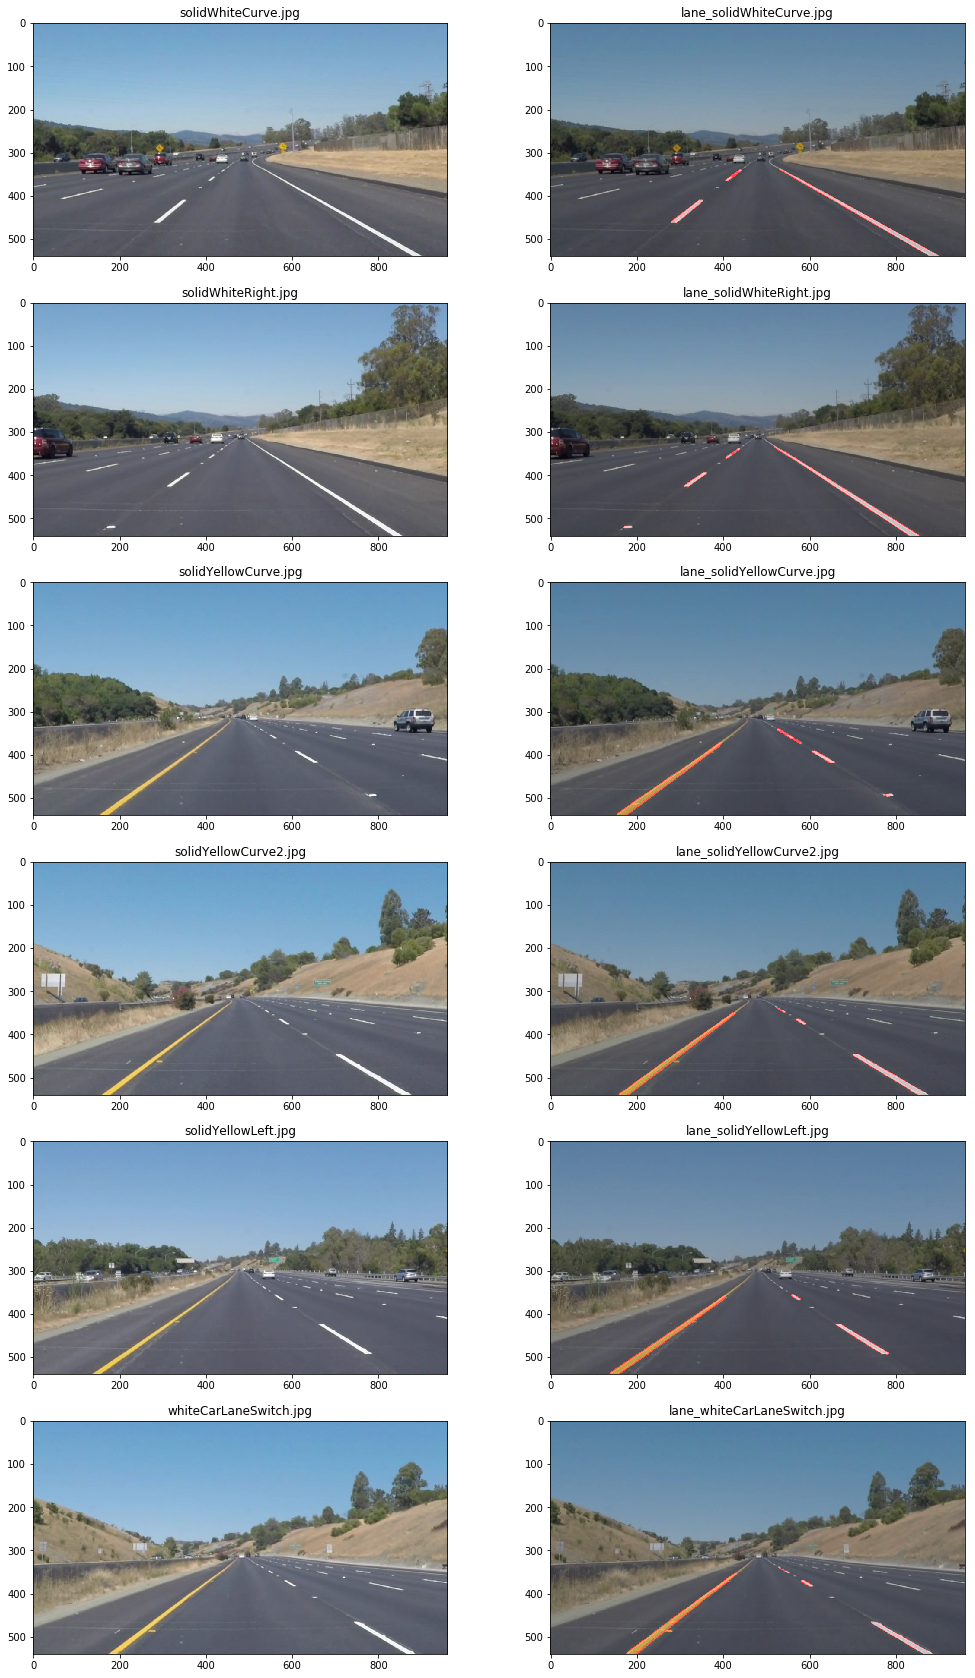

In [8]:
# Pipeline parameters
parameters = {
              'kernel_size': 5,  # Gaussian smoothing parameter
              'low_threshold': 50, # Canny parameter
              'high_threshold': 150, # Canny parameter
              'apex_h': 0.04, # used in mask polygon definition
              'apex_v': 0.6, # used in mask polygon definition
              'rho': 2, # distance resolution in pixels of the Hough grid
              'theta': np.pi / 180, # angular resolution in radians of the Hough grid  
              'threshold': 15,  # minimum number of votes (intersections in Hough grid cell)
              'min_line_length_p': 0.02, # minimum number of pixels making up a line min_line_length = image ysize * min_line_length_p
              'max_line_gap_p': 0.037,  # maximum gap in pixels between connectable line segments max_line_gap = image ysize * max_line_gap_p 
              'Hough_only':True, # draw raw lines only
              'slope_threshold': 0, # used to filter out near horizontal lines 
              'history_length': 10 # number of previous frames to take into account while smoothing (for video only)
             }

# Testing on images, output is written to test_images_output/
run_pipeline("test_images/", "test_hough_output/", parameters)

### Averaged lines test on images

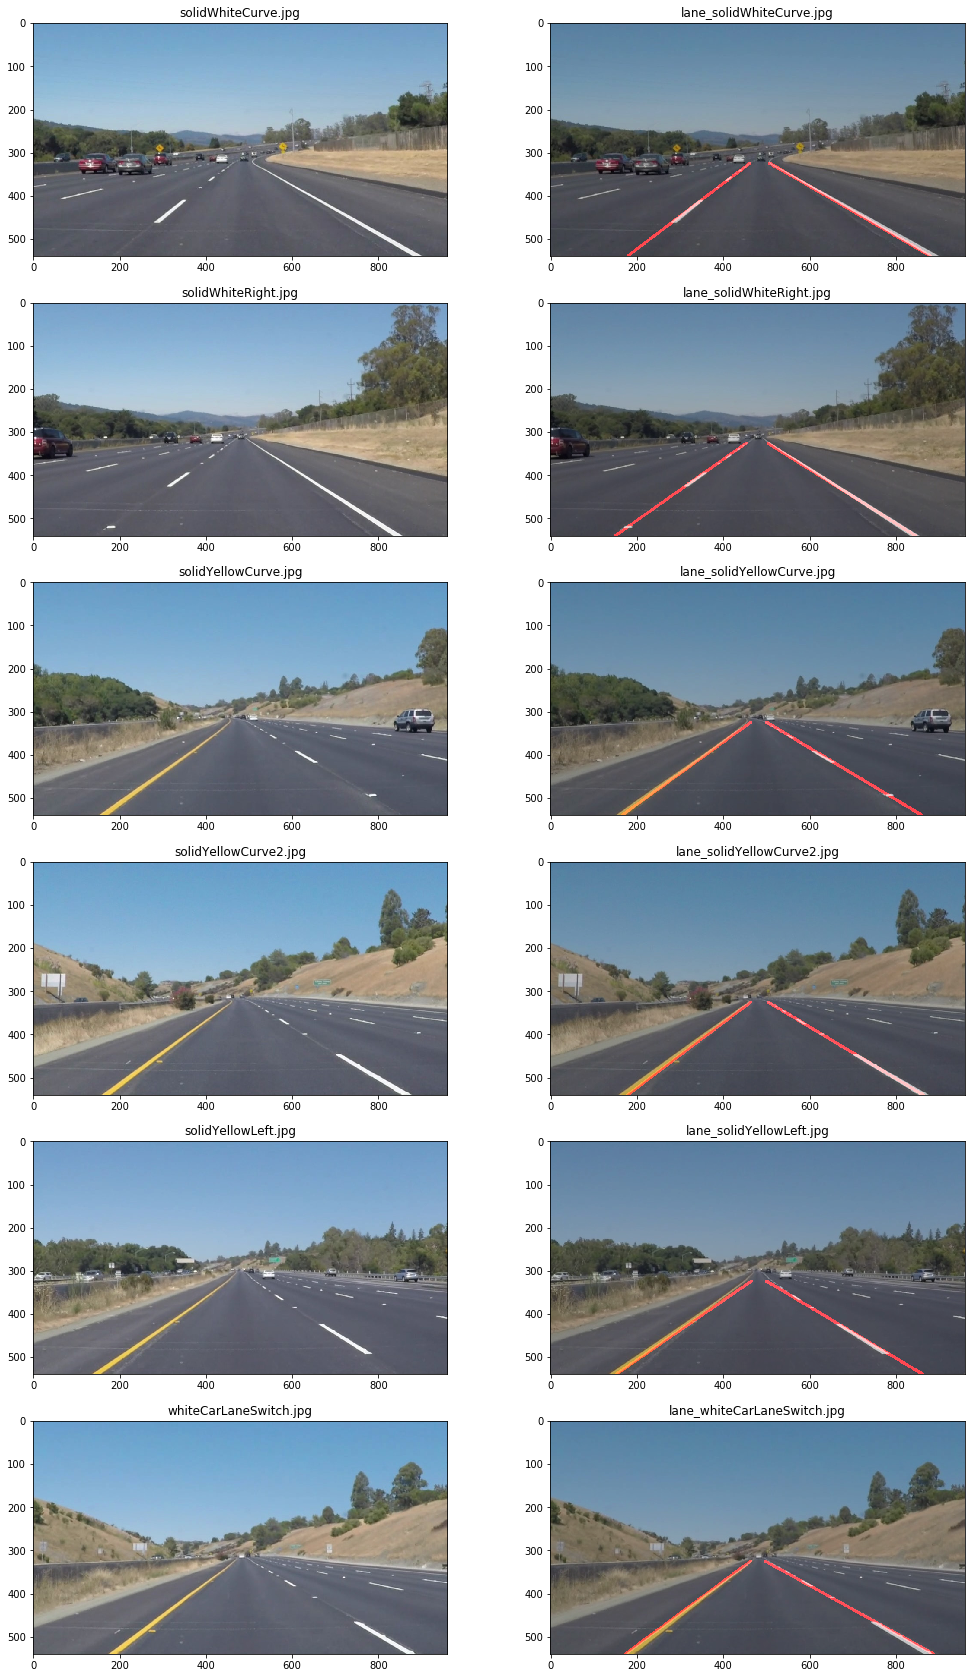

In [9]:
# Pipeline parameters
parameters['Hough_only'] = False    # Draw averaged lines instead of just row lines

# Testing on images, output is written to test_images_output/
run_pipeline("test_images/", "test_images_output/", parameters)

## Test on Videos

You know what's cooler than drawing lanes over images? Drawing lanes over video!

We can test our solution on two provided videos:

`solidWhiteRight.mp4`

`solidYellowLeft.mp4`

**Note: if you get an `import error` when you run the next cell, try changing your kernel (select the Kernel menu above --> Change Kernel).  Still have problems?  Try relaunching Jupyter Notebook from the terminal prompt. Also, check out [this forum post](https://carnd-forums.udacity.com/questions/22677062/answers/22677109) for more troubleshooting tips.**

**If you get an error that looks like this:**
```
NeedDownloadError: Need ffmpeg exe. 
You can download it by calling: 
imageio.plugins.ffmpeg.download()
```
**Follow the instructions in the error message and check out [this forum post](https://carnd-forums.udacity.com/display/CAR/questions/26218840/import-videofileclip-error) for more troubleshooting tips across operating systems.**

In [10]:
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML

In [11]:
# Dictionary to keep history of slopes and intercepts for left and right lines
global_history = {'left':[], 'right':[]}

# Updated to take parameters and historical data into account
def process_image(image):
    # NOTE: The output you return should be a color image (3 channel) for processing video below
    # TODO: put your pipeline here,
    # you should return the final output (image where lines are drawn on lanes)
    result = detect_lanes(image, global_history, parameters)

    return result

Let's try the one with the solid white lane on the right first ...

### Hough lines test on videos

In [12]:
# Pipeline parameters
parameters['Hough_only'] = True  # Draw only raw lines

In [13]:
white_output = 'white.mp4'
clip1 = VideoFileClip("solidWhiteRight.mp4")
global_history = {'left':[], 'right':[]} # Clean up history
white_clip = clip1.fl_image(process_image) #NOTE: this function expects color images!!
%time white_clip.write_videofile(white_output, audio=False)

[MoviePy] >>>> Building video white.mp4
[MoviePy] Writing video white.mp4


100%|███████████████████████████████████████▊| 221/222 [00:08<00:00, 25.45it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: white.mp4 

Wall time: 10.4 s


Play the video inline, or if you prefer find the video in your filesystem (should be in the same directory) and play it in your video player of choice.

In [ ]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(white_output))

## Improve the draw_lines() function

**At this point, if you were successful with making the pipeline and tuning parameters, you probably have the Hough line segments drawn onto the road, but what about identifying the full extent of the lane and marking it clearly as in the example video (P1_example.mp4)?  Think about defining a line to run the full length of the visible lane based on the line segments you identified with the Hough Transform. As mentioned previously, try to average and/or extrapolate the line segments you've detected to map out the full extent of the lane lines. You can see an example of the result you're going for in the video "P1_example.mp4".**

**Go back and modify your draw_lines function accordingly and try re-running your pipeline. The new output should draw a single, solid line over the left lane line and a single, solid line over the right lane line. The lines should start from the bottom of the image and extend out to the top of the region of interest.**

Now for the one with the solid yellow lane on the left. This one's more tricky!

In [15]:
# Pipeline parameters
parameters['Hough_only'] = False    # Draw averaged lines instead of just row lines

In [16]:
yellow_output = 'yellow.mp4'
clip2 = VideoFileClip('solidYellowLeft.mp4')
global_history = {'left':[], 'right':[]} # Clean up history
yellow_clip = clip2.fl_image(process_image)
%time yellow_clip.write_videofile(yellow_output, audio=False)

[MoviePy] >>>> Building video yellow.mp4
[MoviePy] Writing video yellow.mp4


100%|███████████████████████████████████████▉| 681/682 [00:33<00:00, 19.80it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: yellow.mp4 

Wall time: 35.8 s


In [ ]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(yellow_output))

## Writeup and Submission

If you're satisfied with your video outputs, it's time to make the report writeup in a pdf or markdown file. Once you have this Ipython notebook ready along with the writeup, it's time to submit for review! Here is a [link](https://github.com/udacity/CarND-LaneLines-P1/blob/master/writeup_template.md) to the writeup template file.


## Optional Challenge

Try your lane finding pipeline on the video below.  Does it still work?  Can you figure out a way to make it more robust?  If you're up for the challenge, modify your pipeline so it works with this video and submit it along with the rest of your project!

Problems identified:
* Existance of non lane lines caused by shadows, road heterogeneities and car's front edge 
* Lane line dissapearing under sunlight or road heterogeneities
* Some segments are curved    

Get images with identified problems for testing purposes (run once):

In [18]:
clip2 = VideoFileClip('challenge.mp4')
clip2.save_frame('challenge_images/extra40.jpg', t=4, withmask=True)
clip2.save_frame('challenge_images/extra44.jpg', t=4.4, withmask=True)
clip2.save_frame('challenge_images/extra478.jpg', t=4.78, withmask=True)
clip2.save_frame('challenge_images/extra58.jpg', t=5.8, withmask=True)
clip2.save_frame('challenge_images/extra60.jpg', t=6, withmask=True)
clip2.save_frame('challenge_images/extra63.jpg', t=6.3, withmask=True)

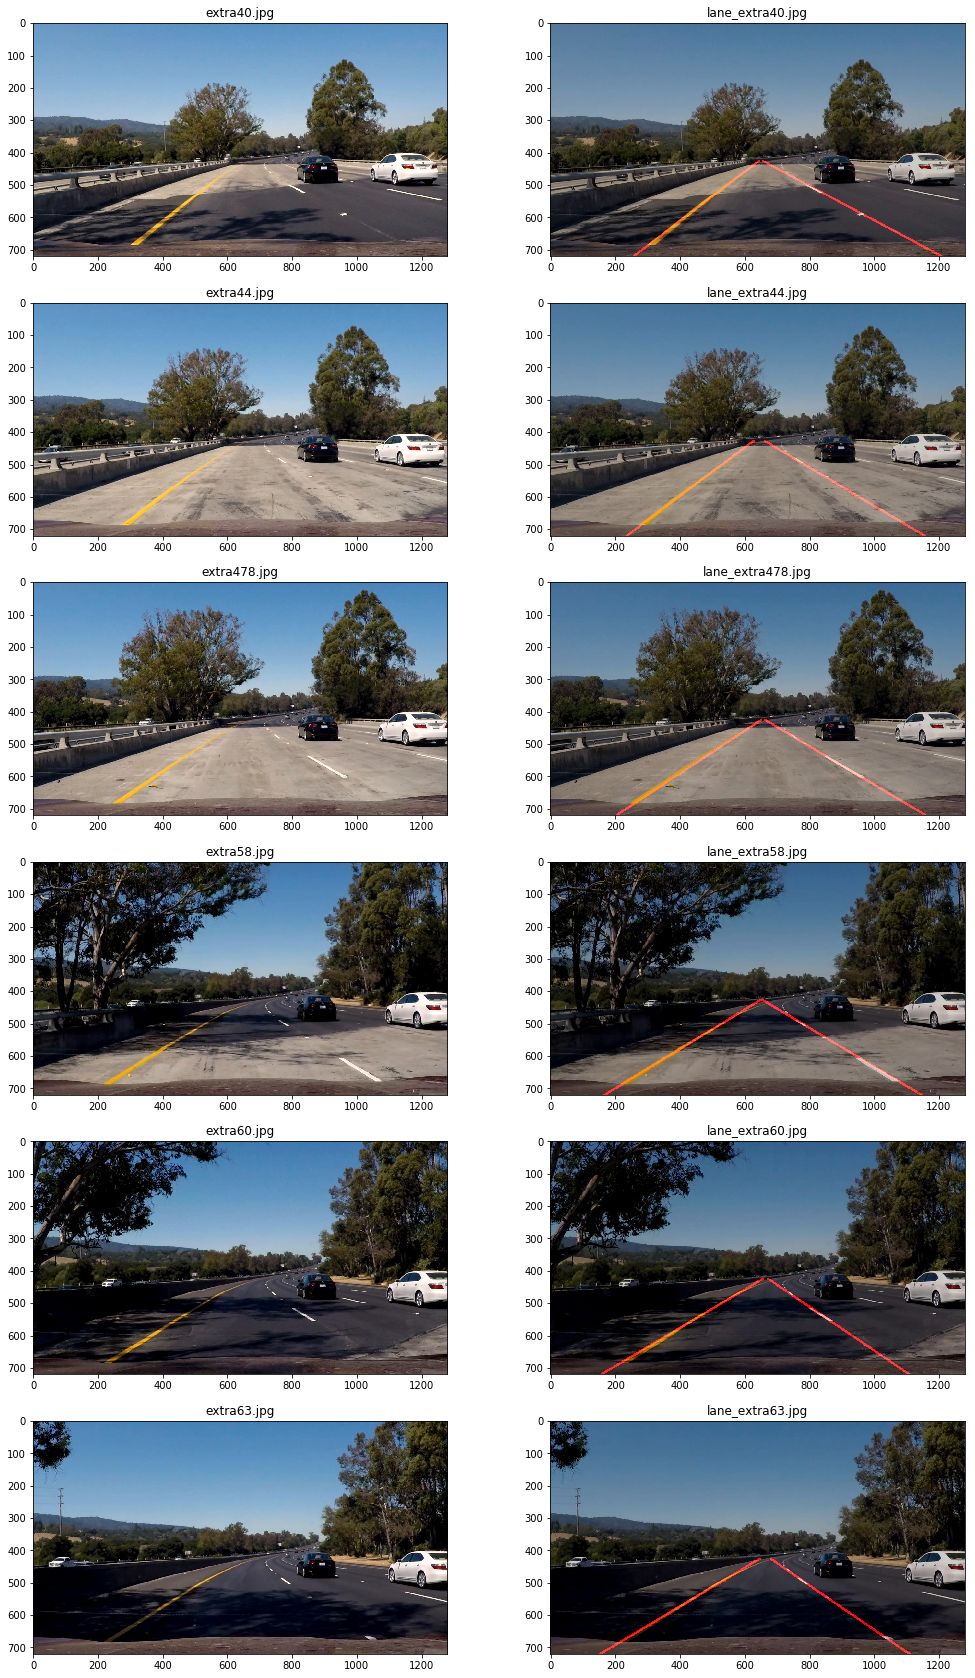

In [19]:
# Pipeline parameters for challenge
parameters = {
              'kernel_size': 5,  # Gaussian smoothing parameter
              'low_threshold': 50, # Canny parameter
              'high_threshold': 150, # Canny parameter
              'apex_h': 0.04, # used in mask polygon definition
              'apex_v': 0.59, # used in mask polygon definition
              'rho': 2, # distance resolution in pixels of the Hough grid
              'theta': np.pi / 180, # angular resolution in radians of the Hough grid  
              'threshold': 15,  # minimum number of votes (intersections in Hough grid cell)
              'min_line_length_p': 0.02, # minimum number of pixels making up a line min_line_length = image ysize * min_line_length_p
              'max_line_gap_p': 0.037,  # maximum gap in pixels between connectable line segments max_line_gap = image ysize * max_line_gap_p 
              'slope_threshold': 0.5,
              'history_length': 10,
              'Hough_only': False  
             }

# Test on images:
run_pipeline("challenge_images/", "challenge_images_output/", parameters)

In [20]:
challenge_output = 'extra.mp4'
clip2 = VideoFileClip('challenge.mp4')
global_history = {'left':[], 'right':[]} # Clean up history
challenge_clip = clip2.fl_image(process_image)
%time challenge_clip.write_videofile(challenge_output, audio=False)

[MoviePy] >>>> Building video extra.mp4
[MoviePy] Writing video extra.mp4


100%|████████████████████████████████████████| 251/251 [00:21<00:00, 11.74it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: extra.mp4 

Wall time: 24.1 s


In [ ]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(challenge_output))